## Welcome to the first-ever (and hopefully last-ever) remote ADA final exam (Fall 2020)

In this exam, you will analyze data from Wikipedia and from the [Wikispeedia](https://dlab.epfl.ch/wikispeedia/play/) game, which you have already encountered in lecture 12 on [“Handling networks”](https://docs.google.com/presentation/d/1h6cIINJ9cNZ-Rtb7SskXrl9Xet5zPUoX2oJlNM0loHQ/edit#slide=id.g464f30ace1_0_92). The rules of the Wikispeedia game are simple:
1. Players are given two Wikipedia articles: a *source* and a *target*.
2. Starting from the source article, the goal is to reach the target, exclusively by following links in the articles encountered along the path.

### The data

The Wikispeedia data comprises ~76K games by human players, thereby capturing human navigation behavior on a very small subset of English Wikipedia comprising ~4.5K articles with a total of ~120K links between them.

The dataset is available in the `data` directory pushed to the same GitHub repo as the exam. Inside the data directory, you will find four files:

####  1. `article_df_task-A.tsv.gz`: A tab-separated file with the following information about Wikipedia articles
- *name*: The name of the Wikipedia article
- *topic*: The top-level topic label for the article (each article is assigned exactly one topic label)
- *content*: The cleaned text of the article (having removed punctuations, stopwords, numbers, and letter casing). It is stored as a space-separated string.

#### 2. `links_task-B.tsv.gz`: A tab-separated file containing Wikipedia links
- *linkSource*: The name of the source Wikipedia article from which the link originates
- *linkTarget*: The name of the target Wikipedia article to which the link points

#### 3.  `paths_df_task-B.tsv.gz`: A tab-separated file with the following information about the played games
- *hashed_ip_address*: Anonymized IP address of the player
- *source*: The name of the Wikipedia article from where the game started
- *target*: The name of the target article that the player was supposed to reach 
- *finished*: Whether the game was successfully finished (whether the player reached the target article)
- *human_path_length*: The number of clicks made by the player, before they either reached the target (in *finished* games) or gave up (in *unfinished* games)
- *shortest_path_length*: The minimum number of clicks required to reach the target article from the source article. Disconnected source-target article pairs have a shortest_path_length of *-1*.
- *duration_in_sec*: The duration of the game in seconds

#### 4.  `paths_df_task-C.tsv.gz`: In continuation to the task-B paths dataframe, this tab-separated file has the following additional information
- *in_degree_target*: In-degree of the target article, that is the number of incoming links that lead to the target article

*Note: In all the aforementioned files, the first line contains the header information. Additionally, article names are URL-encoded. For example, 'Antonín_Dvořák' is stored as 'Anton%C3%ADn_Dvo%C5%99%C3%A1k'. If needed, you can decode the article names using this code: `from urllib.parse import unquote; unquote('article-name')`.*

In [90]:
''' Some minimalistic imports '''
import pandas as pd
import random
import gzip
import operator
import time
from urllib.parse import unquote

import math
import numpy as np
import scipy.stats as stats
import sklearn

import networkx as nx

from IPython.display import Image
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

# Task A. Can we predict article topic using textual content? (30 points)

*Note-1: For the entire Task A, we will use logistic regression for its scalability and simplicity. Specifically, we will use [SGDClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html) available in `sklearn` with 'log' loss and '5' epochs for training a logistic regression classifier.*

*Note-2: In all the cases where random number generation is required (train-test split, fitting the model, etc.), make sure to use 42 as the random seed.*

### A1. Load the text data and analyze the topic distribution (2 points)
1. Load `data/article_df_task-A.tsv.gz` as a pandas dataframe.   
   *Note: we have already cleaned the text for you!*
2. Print the total number of unique topics. Additionally, using a plot of appropriate type, analyze the article topic distribution.   
   **/Discuss:/** What do you observe? Are different topics equally likely? If not, is there a large disparity between certain highly popular and very rare topics?

In [91]:
article_df = pd.read_csv("data/article_df_task-A.tsv.gz", sep='\t')

Total number of unique topics: 14


<AxesSubplot: >

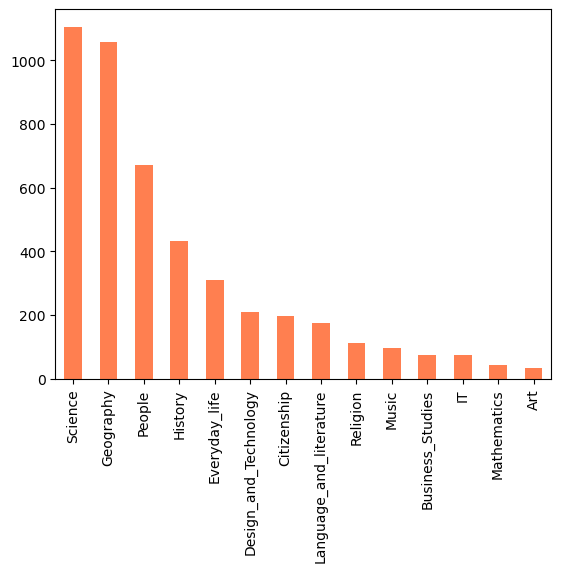

In [92]:
print("Total number of unique topics:", article_df["topic"].nunique())
counts = article_df['topic'].value_counts()
counts.plot(kind='bar', color='coral')

I see that the article topic distribution is an heavy-tailed distribution with two topics getting as many articles as all the other 12 topics combined.

### A2. Topic classification (multi-class): Articles from 5 most frequent topics (8 points)

#### A2.1 Prepping the data for ML (3 points)
1. Restrict the data to articles corresponding to the top-5 topics based on topic frequency.
2. Construct a TF-IDF representation of textual content.
3. Classes are defined by the topic labels, which are given as *strings*. However, for training classifiers via `sklearn` the class labels need to be encoded as ordinals. Perform this encoding and add a new column of ordinal class labels in the current dataframe.
4. Create two numpy arrays: X (TF-IDF representation of each article) and y (class-label of each article).

#### A2.2 Train and evaluate a multi-class classifier (5 points)
1. Perform a train-test split with 70% as the training portion and the remainder as the testing portion. Use `random_state=42` for fixing the seed to 42.
2. Train a logistic regression classifier with L2 regularization using the `SGDClassifier()` method of `sklearn`. Use `SGDClassifier(loss='log', max_iter=5, tol=None, alpha=1e-4, random_state=42)` to initialize the classifier object. Do not modify the settings for any other parameter, let them be set to their default values.   
   **Important heads-up**: *Depending on the configuration of your computer, training the model could take up to 1 minute of compute time.*
3. Report the classifier performance on the test data using accuracy as the metric.
4. **/Discuss:/** Are you satisfied with the model performance? Qualitatively discuss the performance of the model by comparing it to a random baseline and justify your response.

**Important note:** *Based on the discussion in the class, logistic regression is a binary classification technique. A simple heuristic to perform multi-class classification using a binary classifier is to use the [one-vs.-rest (OVR)](https://en.wikipedia.org/wiki/Multiclass_classification#One-vs.-rest) strategy. In this strategy, a binary classifier is trained for each class with the capability to differentiate it from all the other classes, and thus, $k$ binary classifiers are trained for a $k$-class classification. Internally, `SGDClassifier()` uses the [OVR](https://scikit-learn.org/stable/modules/generated/sklearn.multiclass.OneVsRestClassifier.html) strategy of `sklearn` whenever it sees the number of unique values in the **y** vector to be greater than 2. Thus, you can simply use it as a black-box! The only important point for this part is to make sure that the **y** vector of class-labels should have **5** unique values, one corresponding to each class-label.*

In [128]:
from sklearn.feature_extraction.text import TfidfVectorizer

top5_topics = article_df['topic'].value_counts()[:5].index.tolist()
top5_articles_df = article_df[article_df["topic"].isin(top5_topics)]

tfidf_mc = TfidfVectorizer()
X_mc = tfidf_mc.fit_transform(top5_articles_df["content"])
y_mc = top5_articles_df["topic"].apply(lambda topic: top5_topics.index(topic))

In [94]:
# Train test split
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import train_test_split


X_train_mc, X_test_mc, y_train_mc, y_test_mc = train_test_split(X_mc, y_mc, test_size=0.30, random_state=42)
mc_classifier = SGDClassifier(loss="log", max_iter=5, tol=None, alpha=1e-4, random_state=42)
mc_classifier.fit(X_train_mc, y_train_mc)
mc_classifier.score(X_test_mc, y_test_mc)

/home/mpello/.conda/envs/adaexam/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:165: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(


0.8780260707635009

I think the model is good, $0.88$ accuracy is not bad but it doesn't tell the whole story, we should look at the F1 score to understand if the model can actually predict well all class labels, because by only looking at accuracy we might think we have a good model but maybe we have a model that only predicts the two most frequent class labels.

### A3. Topic classification (binary): Articles from the most and least frequent topics (12 points)

#### A3.1 Train and evaluate a binary classifier (2 points)
1. Restrict the data to articles belonging to the most frequent or to the least frequent topic.
2. Create two numpy arrays: X (TF-IDF representation of each article) and y (class-label of each article).
3. Perform a train-test split with 70% as the training portion and the remainder as the testing portion. Use `random_state=42` for fixing the seed to 42.
4. Train a logistic regression classifier with L2 regularization using the `SGDClassifier()` method of `sklearn`. Use `SGDClassifier(loss='log', max_iter=5, tol=None, alpha=1e-4, random_state=42)` to initialize the classifier object. Do not modify the settings for any other parameter, let them be set to their default values.
5. Report the classifier performance on the test data using accuracy as the metric.

In [102]:
most_frequent_topic = article_df['topic'].value_counts()[:1].index.tolist()
least_frequent_topic = article_df['topic'].value_counts()[-1:][:1].index.tolist()
most_least_topics = [most_frequent_topic[0], least_frequent_topic[0]]
most_least_topics_articles_df = article_df[article_df["topic"].isin(most_least_topics)]

tfids_vec = TfidfVectorizer()
X = tfids_vec.fit_transform(most_least_topics_articles_df["content"])
y = most_least_topics_articles_df["topic"].apply(lambda topic: most_least_topics.index(topic))

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)
classifier = SGDClassifier(loss="log", max_iter=5, tol=None, alpha=1e-4, random_state=42)
classifier.fit(X_train, y_train)
classifier.score(X_test, y_test)

/home/mpello/.conda/envs/adaexam/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:165: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(


0.9678362573099415

#### A3.2 Assessing the evaluation metric (5 points)
1. **/Discuss:/** What is your take on the accuracy obtained in A3.1? Do you think accuracy is the correct evaluation metric for this task? If yes, justify! If not, why not, and what else can be used?
2. If you included additional evaluation metrics in A3.2.1, then perform an empirical analysis of the performance using these metrics.   
   **/Discuss:/** Additionally, discuss what you observe. Is it harder to predict the topic labels of certain articles? Why, or why not? Please elaborate!

I dont think this evaluation metric is correct because it does not let us understand whether the model can predict well all classes, it might just predict always the most frequent class, and never predict the not frequent one. We can check this by computing the f1 score and seeing what score we get

In [103]:
from sklearn.metrics import f1_score

y_pred = classifier.predict(X_test)
f1_score(y_true=y_test, y_pred=y_pred)

0.26666666666666666

The f1-score is very low compared to the accuracy, this is because the recall is very low

#### A3.3 Class proportions (5 points)
1. **/Discuss:/** Does the disparity in class proportions hurt the model? If yes, how can you fix it? If not, why not? Justify your response with clear and crisp reasons!    
   *Hint: The learning objective of a classifier can be modified by altering the importance of each class in the computation of the loss function.*
2. If your answer to the aforementioned question is a "yes", please do the following. If not, move to **Task A4**.
    * Implement the fix you proposed in A3.3.1, and repeat the classification task performed in Step A3.1 using the fixed model.
    * Vary the regularization parameter `alpha` in the range [1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1], and using accuracy as the metric find and report its optimal value using 5-fold cross validation on the training set.   
       **Important heads-up**: *Depending on the configuration of your computer, grid search for the optimal value of `alpha` could take up to 1 minute of compute time.*
    * Lastly, using the optimal `alpha` identified in the previous step, redo the evaluations proposed in A3.2.   
       **/Discuss:/** Do you observe any differences from the results obtained in A3.2? Why, or why not? Please elaborate!

The disparity of the classes definitely hurts the model as it never learns to predict the least frequent classes, we can fix by changing how we sample data (right now we are sampling it uniformly) or by adding class weights during model training, assigning a bigger loss on missclassification of less frequent classes (inverse-frequency weighting)

In [110]:
from sklearn.model_selection import StratifiedKFold

K = 5
skf = StratifiedKFold(n_splits=K)
reg_values = [1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1]
best_reg = reg_values[0]
best_accuracy = -1

for reg in reg_values:
    accuracy = 0

    for train_index, test_index in skf.split(X, y):
        X_train_k = X[train_index]
        X_test_k = X[test_index]
        y_train_k = y.iloc[train_index]
        y_test_k = y.iloc[test_index]
        classifier = SGDClassifier(loss="log", max_iter=5, tol=None, alpha=reg, random_state=42, class_weight="balanced")
        classifier.fit(X_train_k, y_train_k)
        accuracy_k = classifier.score(X_test_k, y_test_k)
        accuracy += accuracy_k

    accuracy /= K
    print("regularization:", reg, "accuracy:", accuracy)
    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_reg = reg

classifier = SGDClassifier(loss="log", max_iter=5, tol=None, alpha=best_reg, random_state=42, class_weight="balanced")
classifier.fit(X_train, y_train)
y_pred = classifier.predict(X_test)
print("F1-score:", f1_score(y_true=y_test, y_pred=y_pred))
print("Best reg:", best_reg)
print("Best acc:", best_accuracy)

/home/mpello/.conda/envs/adaexam/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:165: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(
/home/mpello/.conda/envs/adaexam/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:165: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(
/home/mpello/.conda/envs/adaexam/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:165: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(
/home/mpello/.conda/envs/adaexam/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:165: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'

regularization: 1e-06 accuracy: 0.9877038411005487
regularization: 1e-05 accuracy: 0.9938519205502743
regularization: 0.0001 accuracy: 0.9956101708014529


/home/mpello/.conda/envs/adaexam/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:165: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(
/home/mpello/.conda/envs/adaexam/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:165: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(
/home/mpello/.conda/envs/adaexam/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:165: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(
/home/mpello/.conda/envs/adaexam/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:165: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'

regularization: 0.001 accuracy: 0.9956101708014529
regularization: 0.01 accuracy: 0.9956101708014529
regularization: 0.1 accuracy: 0.9956063065151867
F1-score: 0.8695652173913043
Best reg: 0.0001
Best acc: 0.9956101708014529


/home/mpello/.conda/envs/adaexam/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:165: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(
/home/mpello/.conda/envs/adaexam/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:165: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(
/home/mpello/.conda/envs/adaexam/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:165: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(
/home/mpello/.conda/envs/adaexam/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:165: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'

### A4. Revisiting Multi-class classifier of A2.2 (4 points)

1. Print and analyze the confusion matrix for the multi-class model trained in A2.2. **/Discuss:/** What do you observe? Please elaborate!
2. **/Discuss:/** Similar to A3.3, does the disparity in class proportions hurt the model? If yes, how can you fix it? If not, why not? Justify your response with clear and crisp reasons!
3. If your answer to the aforementioned question is a "yes", please do the following. If not, move to **Task A5**.
    * Implement the fix you proposed in A4.2, and repeat the classification task performed in Step A2.2 using the fixed model.
    * Vary the regularization parameter `alpha` in the range [1e-6, 1e-5, 1e-4, 1e-3], and using accuracy as the metric find and report its optimal value using 5-fold cross validation on the training set.   
       **Important heads-up**: *Depending on the configuration of your computer, grid search for the optimal value of `alpha` could take up to 2 minutes of compute time.*
    * Lastly, using the optimal `alpha` identified in the previous step, obtain the accuracy and confusion matrix.
4. **/Discuss:/** Contrast the confusion matrix obtained in A4.1 with the one obtained in A4.3. Do you observe any differences? Why, or why not? Please elaborate!

In [113]:
from sklearn.metrics import confusion_matrix

y_pred = mc_classifier.predict(X_test_mc)
cm = confusion_matrix(y_test_mc, y_pred)
cm

array([[326,   0,   4,   0,   0],
       [ 17, 297,   1,   2,   0],
       [  5,   3, 180,  11,   1],
       [  3,  14,  28,  84,   0],
       [ 23,   5,  13,   1,  56]])

In [114]:
from sklearn.model_selection import StratifiedKFold

K = 5
skf = StratifiedKFold(n_splits=K)
reg_values = [1e-6, 1e-5, 1e-4, 1e-3]
best_reg = reg_values[0]
best_accuracy = -1

for reg in reg_values:
    accuracy = 0

    for train_index, test_index in skf.split(X_mc, y_mc):
        X_train_k = X_mc[train_index]
        X_test_k = X_mc[test_index]
        y_train_k = y_mc.iloc[train_index]
        y_test_k = y_mc.iloc[test_index]
        classifier = SGDClassifier(loss="log", max_iter=5, tol=None, alpha=reg, random_state=42, class_weight="balanced")
        classifier.fit(X_train_k, y_train_k)
        accuracy_k = classifier.score(X_test_k, y_test_k)
        accuracy += accuracy_k

    accuracy /= K
    print("regularization:", reg, "accuracy:", accuracy)
    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_reg = reg

classifier = SGDClassifier(loss="log", max_iter=5, tol=None, alpha=best_reg, random_state=42, class_weight="balanced")
classifier.fit(X_train_mc, y_train_mc)
y_pred = classifier.predict(X_test_mc)
print("Best reg:", best_reg)
print("Best acc:", best_accuracy)
cm = confusion_matrix(y_test_mc, y_pred)
cm

/home/mpello/.conda/envs/adaexam/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:165: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(
/home/mpello/.conda/envs/adaexam/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:165: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(
/home/mpello/.conda/envs/adaexam/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:165: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(
/home/mpello/.conda/envs/adaexam/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:165: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'

regularization: 1e-06 accuracy: 0.887709497206704


/home/mpello/.conda/envs/adaexam/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:165: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(
/home/mpello/.conda/envs/adaexam/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:165: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(
/home/mpello/.conda/envs/adaexam/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:165: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(
/home/mpello/.conda/envs/adaexam/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:165: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'

regularization: 1e-05 accuracy: 0.8935754189944134


/home/mpello/.conda/envs/adaexam/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:165: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(
/home/mpello/.conda/envs/adaexam/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:165: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(
/home/mpello/.conda/envs/adaexam/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:165: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(
/home/mpello/.conda/envs/adaexam/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:165: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'

regularization: 0.0001 accuracy: 0.8888268156424581


/home/mpello/.conda/envs/adaexam/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:165: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(
/home/mpello/.conda/envs/adaexam/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:165: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(
/home/mpello/.conda/envs/adaexam/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:165: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(
/home/mpello/.conda/envs/adaexam/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:165: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'

regularization: 0.001 accuracy: 0.8553072625698324


/home/mpello/.conda/envs/adaexam/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:165: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(


Best reg: 1e-05
Best acc: 0.8935754189944134


array([[322,   1,   5,   0,   2],
       [ 13, 298,   2,   3,   1],
       [  3,   1, 178,  15,   3],
       [  1,   9,  25,  93,   1],
       [ 13,   5,   5,   3,  72]])

### A5. Interpretability (4 points)
1. For each of the 5-classes considered in **A4**, obtain a list of top-10 words (sorted in descending order of their importance) based on the feature weights learned by the classifier.

2. **/Discuss:/** Qualitatively discuss the relevance of the identified words and their association with the respective class-labels. Is the classifier correct to assign them high weights? Are they truly discriminative/predictive of the respective class-labels? Justify your responses with clear and crisp reasons!

In [ ]:
feature_names = tfidf_mc.get_feature_names_out()
coefs = np.array(classifier.coef_)
topk = 10

for i, coef in enumerate(coefs):
    # get indices of top positive weights
    top_idx = np.argsort(coef)[-topk:][::-1]

    print("top 10 words for topic", top5_topics[i])
    print([feature_names[idx] for idx in top_idx])

top 10 words for topic Science
['species', 'genus', 'classification', 'birds', 'scientific', 'orbit', 'moon', 'disease', 'mol', 'energy']
top 10 words for topic Geography
['city', 'population', 'river', 'area', 'island', 'geography', 'sea', 'country', 'islands', 'capital']
top 10 words for topic People
['career', 'born', 'died', 'father', 'work', 'life', 'death', 'married', 'son', 'later']
top 10 words for topic History
['war', 'battle', 'bc', 'history', 'burnside', 'century', 'seacole', 'klan', 'empire', 'chola']
top 10 words for topic Everyday_life
['game', 'asparagus', 'sleep', 'dance', 'astrology', 'garden', 'love', 'lego', 'apricot', 'wrestling']


# Task B. The Wikipedia link network (30 points)

### B1. Wikipedia network: reveal your shape! (12 points)
#### B1.1 Load the Wikipedia link network (`data/links_task-B.tsv.gz`) into memory as a directed graph using `NetworkX`. (4 points)
1. Compute the following from the loaded graph object:
    * the number of nodes,
    * the number of edges, and
    * the average degree.
2. **/Discuss:/** In order to summarize the degree distribution in a single number, would you recommend using the average degree? Why, or why not? If not, what alternatives can you think of? Please elaborate!

In [156]:
edges_df = pd.read_csv("data/links_task-B.tsv.gz", sep='\t')
G = nx.from_pandas_edgelist(edges_df, 'linkSource', 'linkTarget', edge_attr=None, create_using = nx.DiGraph())
print(nx.info(G))
degrees = dict(G.degree(G.nodes()))
print("Average degree:", sum(degrees.values()) / len(G.nodes()))

DiGraph with 4592 nodes and 119882 edges
Average degree: 52.21341463414634


/tmp/ipykernel_114840/3445691718.py:3: DeprecationWarning: info is deprecated and will be removed in version 3.0.

  print(nx.info(G))


The average degree makes sense only if we know that the distribution of degrees in the network is not skewed or heavy-tailed. But, graph theory tells us that the degree distribution is very often skewed of heavy tailed, so we should use instead robust statistics like the median

#### B1.2 Using the appropriate plot type, plot the in-degree and out-degree distributions of the Wikipedia link network and analyze it. (4 points)
1. **/Discuss:/** What is the appropriate scale of the axes?
2. **/Discuss:/** Does the distribution (roughly) follow a particular distribution, and if yes, which one? Additionally, explain how you arrived at your conclusion.

The appropriate scale of the x-axis is logarithmic as the degree distribution is clearly very skewed. It seems to follow a power law distribution where there are some outliers that are rare but not very rare and then there is the rest.

Text(0.5, 1.0, 'Degree distribution for the Quaker network')

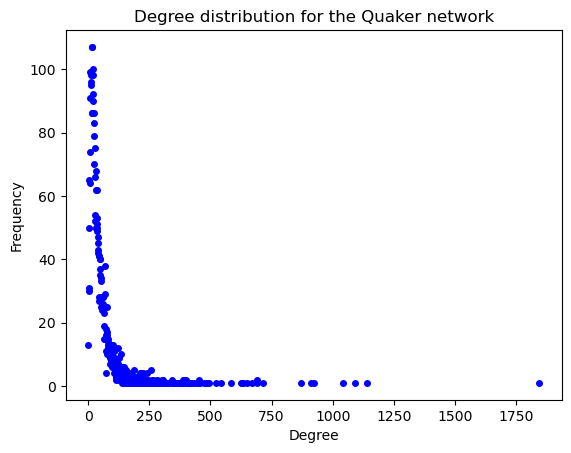

In [157]:
# Degree Distribution Scatter plot
import collections
from operator import itemgetter

in_degrees = dict(G.in_degree(G.nodes()))
sorted_degree = sorted(degrees.items(), key=itemgetter(1), reverse=True)
degree_seq = [d[1] for d in sorted_degree]
degreeCount = collections.Counter(degree_seq)
degreeCount = pd.DataFrame.from_dict( degreeCount, orient='index').reset_index()
fig = plt.figure()
ax = plt.gca()
ax.plot(degreeCount['index'], degreeCount[0], 'o', c='blue', markersize= 4)
plt.ylabel('Frequency')
plt.xlabel('Degree')
plt.title('Degree distribution for the Quaker network')

Text(0.5, 1.0, 'Degree distribution for the Quaker network')

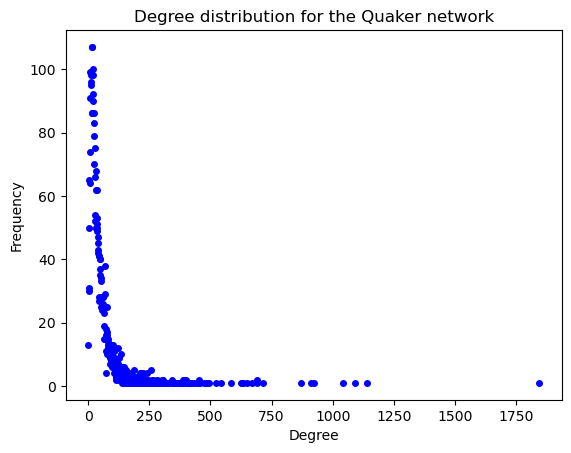

In [158]:
# Degree Distribution Scatter plot
import collections
from operator import itemgetter

out_degrees = dict(G.out_degree(G.nodes()))
sorted_degree = sorted(degrees.items(), key=itemgetter(1), reverse=True)
degree_seq = [d[1] for d in sorted_degree]
degreeCount = collections.Counter(degree_seq)
degreeCount = pd.DataFrame.from_dict( degreeCount, orient='index').reset_index()
fig = plt.figure()
ax = plt.gca()
ax.plot(degreeCount['index'], degreeCount[0], 'o', c='blue', markersize= 4)
plt.ylabel('Frequency')
plt.xlabel('Degree')
plt.title('Degree distribution for the Quaker network')

#### B1.3 Connectedness of the Wikipedia link network (4 points)

**Definition-1:** An undirected graph $G$ is said to be connected if, for every pair of vertices $(u, v)$, it contains a path that connects the two vertices.

**Definition-2:** A directed graph $G_{dir}$ is **weakly connected** (or simply connected) if the underlying undirected graph obtained by replacing all directed edges of the graph with undirected edges is a connected graph (cf. Definition-1). 

**Definition-3:** A directed graph $G_{dir}$ is **strongly connected** if, for every pair of vertices $(u, v)$, it contains a directed path from $u$ to $v$ and a directed path from $v$ to $u$.

Given these definitions, what can you say about the connectedness of the Wikipedia link network? Specifically, answer the following:
1. Is the Wikipedia link network weakly connected? If not, print the number of weakly connected components. Additionally, print the number of nodes and edges of the subgraph corresponding to the largest weakly connected component.
2. Is the Wikipedia link network strongly connected? If not, print the number of strongly connected components. Additionally, print the number of nodes and edges of the subgraph corresponding to the largest strongly connected component.

In [175]:
undirectedG = G.to_undirected()


In [176]:
print(f"The undirected graph made from the directed one is{'' if nx.is_connected(undirectedG) else ' not'} connected")
conn_components = [comp for comp in nx.connected_components(undirectedG)]
print("Number of connected components:", len(conn_components))
biggest_component = None
for component in conn_components:
    if biggest_component is None or len(component) > len(biggest_component):
        biggest_component = component
print("Number of nodes and edges:", nx.info(undirectedG.subgraph(biggest_component)))

The undirected graph made from the directed one is not connected
Number of connected components: 2
Number of nodes and edges: Graph with 4589 nodes and 106644 edges


/tmp/ipykernel_114840/2262515256.py:8: DeprecationWarning: info is deprecated and will be removed in version 3.0.

  print("Number of nodes and edges:", nx.info(undirectedG.subgraph(biggest_component)))


In [181]:
print(f"The directed graph is{'' if nx.is_strongly_connected(G) else ' not'} strongly connected")
strong_conn_components = [comp for comp in nx.strongly_connected_components(G)]
print("Number of strongly connected components:", len(strong_conn_components))
biggest_strong_component = None
for component in strong_conn_components:
    if biggest_strong_component is None or len(component) > len(biggest_strong_component):
        biggest_strong_component = component
print("Number of nodes and edges:", nx.info(G.subgraph(biggest_strong_component)))

The directed graph is not strongly connected
Number of strongly connected components: 519
Number of nodes and edges: DiGraph with 4051 nodes and 111900 edges


/tmp/ipykernel_114840/3416825774.py:8: DeprecationWarning: info is deprecated and will be removed in version 3.0.

  print("Number of nodes and edges:", nx.info(G.subgraph(biggest_strong_component)))


### B2. The interplay between human navigation behavior and Wikipedia network structure (18 points)

#### B2.1 Loading and analyzing the game data (3 points)
1. Load `data/paths_df_task-B.tsv.gz` as a pandas dataframe.
2. Some games were successfully finished (*finished=True*) while others were unsuccessful (i.e., the player gave up before reaching the target article). However, not all unsuccessful games are infeasible; the player might simply not have been good enough at the game to reach the target from the source. **/Discuss:/** Clearly state the reasons why there may be games that are *truly infeasible*.   
3. List all unsuccessful games that are *truly infeasible* and remove them from the dataframe.

In [203]:
paths_df = pd.read_csv("data/paths_df_task-B.tsv.gz", sep='\t')
impossible_games = paths_df[(paths_df["finished"] == False) & (paths_df["shortest_path_length"] == -1)]
print(impossible_games)
paths_df = paths_df.drop(impossible_games.index)

      hashed_ip_address             source                          target  \
53533  4c03b8fb18fc9752   Oasis_%28band%29  Final_Fantasy_%28video_game%29   
56880  3af13b307343dec9       Adolf_Hitler                       The_Frogs   
63647  093e40d06992b8dc         Anne_Frank  Final_Fantasy_%28video_game%29   
63648  093e42416992ba4d         Anne_Frank  Final_Fantasy_%28video_game%29   
64511  17ef27577d43939d                Toy                            Lego   
66654  5e55877267bd6864        Hymenoptera      Portuguese_Communist_Party   
71566  3d9b105c56bcf38a   Private_Peaceful                            Unix   
75567  360d256e3fd2a746  Quantum_mechanics                        Blue_Tit   

       finished  human_path_length  shortest_path_length  duration_in_sec  
53533     False                  1                    -1               13  
56880     False                  6                    -1             1874  
63647     False                 21                    -1             

#### B2.2 Wikispeedia => Wikislowia? (9 points)
1. Compute and report the average and median path lengths for games that were successfully finished (*finished=True*). You should compute and report path length in two ways: (1) with respect to the number of clicks needed by *human players*, (2) with respect to the *minimum* number clicks an *optimal player* would need.   
   **/Discuss:/** What can you say about the navigability of the Wikipedia link network?   
   *Hint: Think about [Milgram's experiment](https://docs.google.com/presentation/d/1h6cIINJ9cNZ-Rtb7SskXrl9Xet5zPUoX2oJlNM0loHQ/edit#slide=id.g464f30ace1_0_261) and relate your findings with his findings!*
2. **/Discuss:/** Suppose you want to maliciously decrease Wikipedia's navigability. You are allowed to remove certain edges in the network. What criterion would you use to decide which edges should be removed? Additionally, discuss why these edges are critical for Wikipedia's navigability. Justify your answer with clear and substantive reasoning!   
   _Hint: Navigability of a network depends on the existence of short paths in the network._
3. **/Discuss:/** In continuation to B2.2.2, assume you are given a budget of $k<<n$ edges to be removed. Design the algorithm that you would employ, provide its pseudocode (as a list of steps), and justify your algorithm design choice.   
   *Note: You don't have to describe the steps for computing the criterion you identified in Step B.2.2. Instead, using the identified criterion as a blackbox, you have to provide the steps required to remove $k>1$ edges.*

In [208]:
successful_games = paths_df[paths_df["finished"]]
print("Average optimal length", successful_games["shortest_path_length"].mean())
print("Median optimal length", successful_games["shortest_path_length"].median())
print("Average human length", successful_games["human_path_length"].mean())
print("Median human length", successful_games["human_path_length"].median())

Average optimal length 2.845500253342168
Median optimal length 3.0
Average human length 6.757493081810033
Median human length 6.0


Wikipedia is very navigable, also the distribution does not seem skewed (median and mean are close for the optimal lengths). 

The easiest way would be to remove all the nodes that act as hubs in the network connecting many pages. Just connecting a lot of pages wont be enough because maybe we have pages with many connections but that are rarely part of the shortest paths (which is the ultimate metric we want to increase and worsen). For this reason we should remove nodes using a robust node centrality measure for our scenario, that would be the betweenness centrality measure that counts what percentage of short paths go through which nodes. The algorithm would be: make graph, compute betweeness measure for all nodes, remove the one with the highest betweeneess measure, recompute betweeness, remove again the highest.

#### B2.3 Relationship between network structure and game completion (6 points)
1. Enrich the dataframe with the eigenvector centrality and in-degree of the target article for each game path.
2. Using plots of appropriate type, plot the in-degree distribution of the target articles of game paths. What is the appropriate scale of the axes? Additionally, summarize the in-degree distribution of the target articles in a single number using a suitable metric. Justify your choice of the metric.
3. Using plots of appropriate type, analyze the differences in in-degree and eigenvector centrality of finished and unfinished games.   
   **/Discuss:/** What do you observe? Clearly discuss your observations!

Text(0.5, 1.0, 'Degree distribution for the Quaker network')

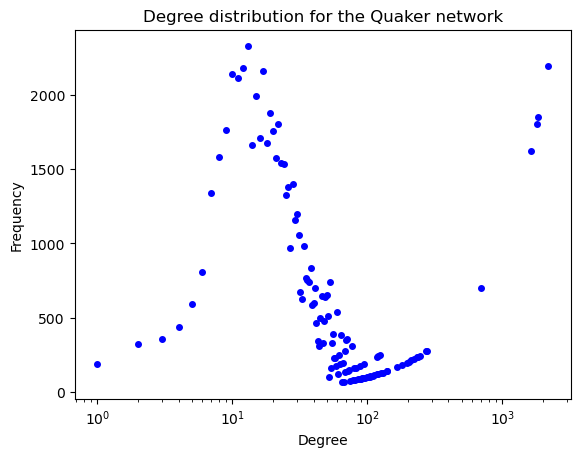

In [224]:
target_counts = paths_df.groupby("target")["target"].count()
paths_df["target_in_degree"] = paths_df["target"].map(target_counts)

sorted_degree = paths_df["target_in_degree"].sort_values()
degreeCount = collections.Counter(sorted_degree)
degreeCount = pd.DataFrame.from_dict( degreeCount, orient='index').reset_index()
fig = plt.figure()
ax = plt.gca()
ax.plot(degreeCount['index'], degreeCount[0], 'o', c='blue', markersize= 4)
plt.xscale("log")
plt.ylabel('Frequency')
plt.xlabel('Degree')
plt.title('Degree distribution for the Quaker network')

In [226]:
paths_df["target_in_degree"].mean()

225.20960606975493

In [227]:
paths_df["target_in_degree"].median()

26.0

It's skewed

Text(0.5, 1.0, 'Degree distribution for the Quaker network')

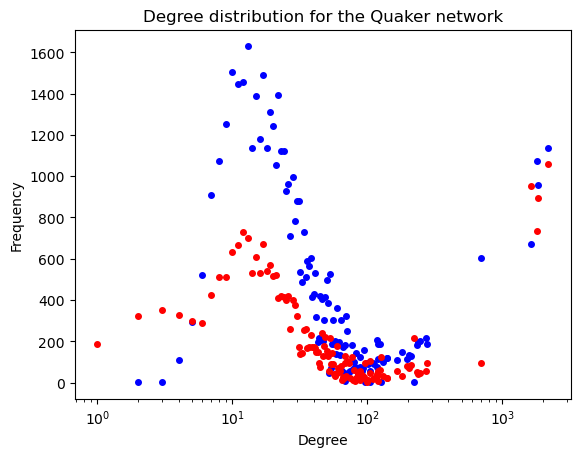

In [ ]:
successful_games = paths_df[paths_df["finished"]]
unsuccessful_games = paths_df[paths_df["finished"] == False]

target_counts = paths_df.groupby("target")["target"].count()
paths_df["target_in_degree"] = paths_df["target"].map(target_counts)

successful_games_target_counts = successful_games["target_in_degree"].sort_values()
s_degreeCount = collections.Counter(successful_games_target_counts)
s_degreeCount = pd.DataFrame.from_dict(s_degreeCount, orient='index').reset_index()

unsuccessful_games_target_counts = unsuccessful_games["target_in_degree"].sort_values()
u_degreeCount = collections.Counter(unsuccessful_games_target_counts)
u_degreeCount = pd.DataFrame.from_dict(u_degreeCount, orient='index').reset_index()

fig = plt.figure()
ax = plt.gca()
ax.plot(s_degreeCount['index'], s_degreeCount[0], 'o', c='blue', markersize= 4)
ax.plot(u_degreeCount['index'], u_degreeCount[0], 'o', c='red', markersize= 4)
plt.xscale("log")
plt.ylabel('Frequency')
plt.xlabel('Degree')
plt.title('Degree distribution for the Quaker network')

# Task C. Putting on the causality hat (30 points)

### C1. Are articles with high in-degree easier to find? A naive analysis (6 points)

Recall that in each Wikispeedia game, a player is **randomly** assigned a source article and a target article. In task **C**, we are interested in measuring the effect of the target article's in-degree on the player's chances of successfully finishing the game.

1. Load `data/paths_df_task-C.tsv.gz` as a pandas dataframe.
2. Consider target articles with fewer than 20 incoming links to have a *low in-degree* and articles with at least 20 to have a *high in-degree*.
3. Calculate the fraction of games with a high-in-degree target that was finished, and the fraction of games with a low-in-degree target that was finished. Do you observe significant differences, and in what direction? (You may do a statistical test or provide confidence intervals.)
4. Repeat the same analysis for the game duration, for finished games only.
5. Quantify and discuss your findings from Steps C1.3 and C1.4.

In [230]:
paths_df = pd.read_csv("data/paths_df_task-C.tsv.gz", sep='\t')
target_counts = paths_df.groupby("target")["target"].count()
paths_df["target_in_degree"] = paths_df["target"].map(target_counts)

In [233]:
high_degree_games = paths_df[paths_df["target_in_degree"] >= 20]
low_degree_games = paths_df[paths_df["target_in_degree"] < 20]

print("Fraction of games with a high in-degree target that were finished:", high_degree_games["finished"].mean())
print("Fraction of games with a low in-degree target that were finished:", low_degree_games["finished"].mean())

Fraction of games with a high in-degree target that were finished: 0.6838685952439323
Fraction of games with a low in-degree target that were finished: 0.6550875775713288


In [236]:
from scipy.stats import ttest_ind

ttest_ind(high_degree_games["finished"], low_degree_games["finished"], axis=0, equal_var=True, nan_policy='propagate')

Ttest_indResult(statistic=8.12264275092687, pvalue=4.628985977000288e-16)

In [238]:
print("Average game duration for finished games with a high in-degree target:", high_degree_games["duration_in_sec"].mean())
print("Average game duration for finished games with a low in-degree target:", low_degree_games["duration_in_sec"].mean())

Average game duration for finished games with a high in-degree target: 362.8461837051565
Average game duration for finished games with a low in-degree target: 408.70271361950574


In [242]:
ttest_ind(high_degree_games["duration_in_sec"], low_degree_games["duration_in_sec"], axis=0)

Ttest_indResult(statistic=-9.129236152900901, pvalue=7.061207191747831e-20)

### C2. Modeling the study setup with a causal diagram (9 points)

**C2.1** We are interested in the effect of target in-degree (**deg(T)**) on the binary outcome **(O)** that captures whether the game was successfully finished or not. In the previously conducted naive analysis, we did not take into account the shortest path length **(L)**, which is the minimum number of clicks necessary in order to reach the target article from the source article **(S)**. Target and source articles are randomly assigned, independently from each other. The assigned source article S and deg(T) affect the shortest path length L. The source article affects the outcome through the shortest path length, and also directly, as some sources might be more central in the network.   
Choose a causal diagram **(A, B, C, D, E, or F)** that corresponds to the described relationships between the following 4 variables. Additionally, justify your choice and explain your reasoning. **(4 points)**
- **deg(T):** target in-degree,
- **L:** shortest path length between source and target,
- **S:** name of source article,
- **O:** outcome, i.e., the binary indicator that says whether the game was successfully finished.

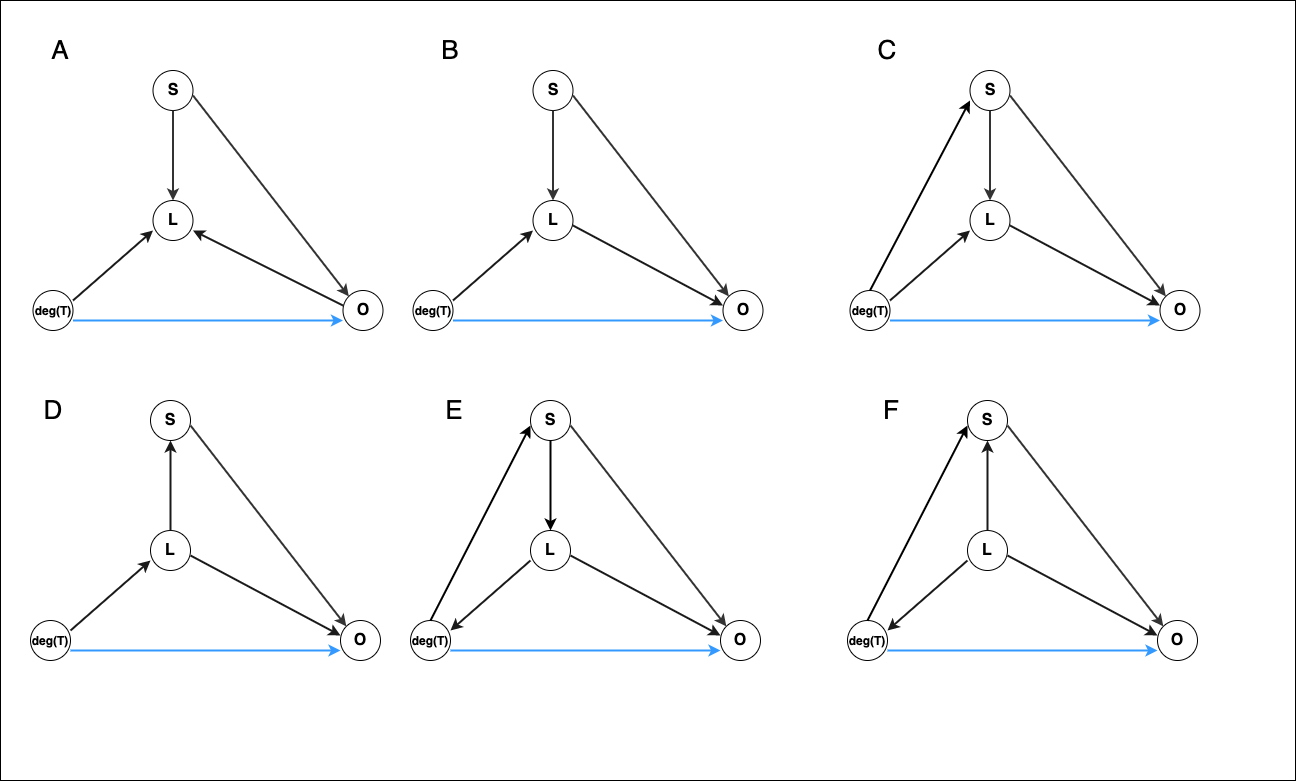

In [ ]:
Image(filename="img/diagram.png")

In [ ]:
'''your answer here''';

**C2.2** **/Discuss:/** What is potentially misleading about the naive analysis done in task **C1**? In what conceivable ways could the conclusions about the impact of target in-degree **deg(T)** on the outcome **O** be wrong?
Could the findings go in the opposite direction of a true direct causal effect? Justify your answer. **(5 points)**

In [ ]:
'''your answer here''';

### C3. A more controlled analysis: matching on source article and shortest path length (15 points)

Let's now understand how the estimated effect of the target in-degree would differ if we controlled for both the source article and the shortest path length between source and target. Construct a set of matched pairs of games. In a matched pair, the two games differ in target in-degree (one has a high in-degree, and the other has a low in-degree), but the source article and the shortest path length are exactly the same. Note that your output must be a 1-to-1 matching.

1. Perform exact matching on source article and shortest path length. This means that two candidate games can be matched only if the source article and the shortest path length are exactly the same. Additionally, report the number of matched pairs of games. **(7 points)**   
   **Important heads-up**: *Depending on the configuration of your computer, computing the exact matching could take up to 3 minutes of compute time.*
2. Among the matched pairs of games, calculate the fraction of games with a high-in-degree target that was successfully finished, and the fraction of games with a low-in-degree target that was successfully finished. Do you observe significant differences, and in what direction? (You may do a statistical test or provide confidence intervals.) **(3 points)**
3. **/Discuss:/** What do you observe? Are the conclusions different from the conclusions reached in C1? If yes, speculate as to why that is the case. How is the estimation in task C1 different from the estimation in task C3? **(4 points)**
4. **/Discuss:/** Based on your findings, how should Wikipedia be modified in order to increase the fraction of finished Wikispeedia games? **(1 points)**

*Hint: How you construct the set of matched pairs is up to you. One way can be to build an unweighted bipartite graph where games with targets with a high in-degree are on one side (the "treated class"), and games with targets with a low in-degree are on the other side (the "control class"). The edge between two matching candidate games is created only if there is an exact match on the source article and the shortest path length. Based on this bipartite graph, you can then find the **optimal** matching. However, note that this is neither the required nor the only way.*

In [274]:
all_matched_high_degree_games = pd.DataFrame()
all_matched_low_degree_games = pd.DataFrame()

for source in high_degree_games["source"].unique():
    for shortest_path_length in high_degree_games[high_degree_games["source"] == source]["shortest_path_length"].unique():
        matched_low_degree_games = low_degree_games[(low_degree_games["source"] == source) & (low_degree_games["shortest_path_length"] == shortest_path_length)]
        if not matched_low_degree_games.empty:
            matched_high_degree_games = high_degree_games[(high_degree_games["source"] == source) & (high_degree_games["shortest_path_length"] == shortest_path_length)]
            all_matched_high_degree_games = pd.concat([all_matched_high_degree_games, matched_high_degree_games])
            all_matched_low_degree_games = pd.concat([all_matched_low_degree_games, matched_low_degree_games])

print("Number of matched pairs", len(all_matched_high_degree_games) + len(all_matched_low_degree_games))

Number of matched pairs 62782


In [276]:
print("Fraction of matched games with a high-in-degree target that were finished", all_matched_high_degree_games["finished"].mean())
print("Fraction of matched games with a low-in-degree target that were finished", all_matched_low_degree_games["finished"].mean())

Fraction of matched games with a high-in-degree target that were finished 0.6771747610688512
Fraction of matched games with a low-in-degree target that were finished 0.6735734631994854


In [277]:
ttest_ind(all_matched_high_degree_games["finished"].apply(lambda x: 1 if x else 0), all_matched_low_degree_games["finished"].apply(lambda x: 1 if x else 0), axis=0)

Ttest_indResult(statistic=0.9175544291697558, pvalue=0.3588557098695512)